In [2]:
import sys
sys.path.append('../..')

## Trimming mesh with PyVista

In [3]:
import pyvista as pv

In [4]:
mesh_x = pv.read('/Users/knpob/Downloads/S6_nude_jump120_0309_0372/meshes/S6_nude_jump120_0309_0372.000001.obj')
texture_x = pv.read_texture('/Users/knpob/Downloads/S6_nude_jump120_0309_0372/meshes/S6_nude_jump120_0309_0372.000001.jpg')
mesh_y = pv.read('/Users/knpob/Downloads/S6_nude_jump120_0309_0372/meshes/S6_nude_jump120_0309_0372.000032.obj')
texture_y = pv.read_texture('/Users/knpob/Downloads/S6_nude_jump120_0309_0372/meshes/S6_nude_jump120_0309_0372.000032.jpg')

mesh_x, mesh_y

(PolyData (0x12f66bdc0)
   N Cells:    96048
   N Points:   288144
   N Strips:   0
   X Bounds:   -1.399e+03, 1.111e+03
   Y Bounds:   -6.370e+02, 9.704e+02
   Z Bounds:   -1.400e+03, 1.065e+03
   N Arrays:   6,
 PolyData (0x149ec12a0)
   N Cells:    98605
   N Points:   295815
   N Strips:   0
   X Bounds:   -1.400e+03, 1.149e+03
   Y Bounds:   -6.239e+02, 1.148e+03
   Z Bounds:   -1.400e+03, 4.273e+02
   N Arrays:   6)

In [4]:
mesh_x_c = mesh_x.clean().split_bodies()[0].extract_surface().triangulate()
mesh_y_c = mesh_y.clean().split_bodies()[0].extract_surface().triangulate()
# mesh_x_c.plot()
# mesh_y_c.plot()

In [5]:
mesh_x_c.save('output/3dmd/x_clean.ply')
mesh_y_c.save('output/3dmd/y_clean.ply')
# pv.read('output/3dmd/x_clean.ply').plot()
# pv.read('output/3dmd/y_clean.ply').plot()

In [6]:
mesh_x_c

PolyData (0x11e6e37c0)
  N Cells:    65244
  N Points:   32796
  N Strips:   0
  X Bounds:   -5.501e+02, 5.705e+02
  Y Bounds:   -5.950e+02, 9.704e+02
  Z Bounds:   -1.806e+02, 1.853e+02
  N Arrays:   9

## Mesh simplification with PyMeshLab

In [7]:
import pymeshlab as ml

def mesh_simplify(input_mesh_path, output_mesh_path, target_vertex_count):
    ms = ml.MeshSet()
    ms.load_new_mesh(input_mesh_path)
    m = ms.current_mesh()
    print('input mesh has', m.vertex_number(), 'vertex and', m.face_number(), 'faces')

    # Clean-up in case of input has duplicate/unreferenced vertices
    ms.meshing_remove_duplicate_vertices()
    ms.meshing_remove_unreferenced_vertices()

    # Initial estimation number of faces, designed to be superior than the teorical value
    numFaces = 100 + ms.current_mesh().face_number() - (ms.current_mesh().vertex_number() - target_vertex_count)

    # Simplify the mesh
    while (ms.current_mesh().vertex_number() > target_vertex_count):
        ms.meshing_decimation_quadric_edge_collapse(targetfacenum=numFaces, preservenormal=True)
        # Refine our estimation to slowly converge to TARGET vertex number
        numFaces = numFaces - (ms.current_mesh().vertex_number() - target_vertex_count)

    print("mesh decimated to", numFaces, "faces contains", ms.current_mesh().vertex_number(), "vertex")

    # num_holes_after = ms.current_mesh().bounding_box().hole_number()
    # print("Number of holes after:", num_holes_after)

    m = ms.current_mesh()
    print('output mesh has', m.vertex_number(), 'vertex and', m.face_number(), 'faces')
    ms.save_current_mesh(output_mesh_path)

mesh_simplify(
    input_mesh_path='output/3dmd/x_clean.ply',
    output_mesh_path='output/3dmd/x_simplified.ply',
    target_vertex_count=5000,
)
mesh_simplify(
    input_mesh_path='output/3dmd/y_clean.ply',
    output_mesh_path='output/3dmd/y_simplified.ply',
    target_vertex_count=5000,
)

input mesh has 32796 vertex and 65244 faces
mesh decimated to 9713 faces contains 5000 vertex
output mesh has 5000 vertex and 9712 faces
input mesh has 35016 vertex and 69850 faces
mesh decimated to 9841 faces contains 5000 vertex
output mesh has 5000 vertex and 9840 faces


In [5]:
mesh_x_c_s = pv.read('output/3dmd/x_simplified.ply')
mesh_y_c_s = pv.read('output/3dmd/y_simplified.ply')
# mesh_x_c_s.plot()
# mesh_y_c_s.plot()

## LBO

In [6]:
import torch
import numpy as np
from src.utils.geometry import compute_operators, torch2np, sparse_torch_to_np

def get_verts_and_faces(mesh):
    points = mesh.points                 # shape (V, 3)
    faces = mesh.faces.reshape(-1, 4)    # shape (F, 4)
    tri_faces = faces[:, 1:4]            # shape (F, 3)

    return np.array(points), np.array(tri_faces)

def lbo(mesh, save_path, k_eig=200, is_pcd = False):
    verts, faces = get_verts_and_faces(mesh)

    frames, mass_vec, L, evals, evecs, gradX, gradY = compute_operators(
        torch.from_numpy(verts).float(),
        torch.from_numpy(faces).long() if not is_pcd else None,
        k=k_eig,
    )

    frames_np = torch2np(frames).astype(np.float32)
    mass_np = torch2np(mass_vec).astype(np.float32)
    evals_np = torch2np(evals).astype(np.float32)
    evecs_np = torch2np(evecs).astype(np.float32)
    L_np = sparse_torch_to_np(L).astype(np.float32)
    gradX_np = sparse_torch_to_np(gradX).astype(np.float32)
    gradY_np = sparse_torch_to_np(gradY).astype(np.float32)

    np.savez(
        save_path,
        verts=verts,
        faces=faces,
        k_eig=k_eig,
        frames=frames_np,
        mass=mass_np,
        evals=evals_np,
        evecs=evecs_np,
        L_data=L_np.data,
        L_indices=L_np.indices,
        L_indptr=L_np.indptr,
        L_shape=L_np.shape,
        gradX_data=gradX_np.data,
        gradX_indices=gradX_np.indices,
        gradX_indptr=gradX_np.indptr,
        gradX_shape=gradX_np.shape,
        gradY_data=gradY_np.data,
        gradY_indices=gradY_np.indices,
        gradY_indptr=gradY_np.indptr,
        gradY_shape=gradY_np.shape,
    )

lbo(mesh_x_c_s, 'output/3dmd/x_spectral.npz')
lbo(mesh_y_c_s, 'output/3dmd/y_spectral.npz')
lbo(mesh_x_c_s, 'output/3dmd/x_pcd_spectral.npz', is_pcd=True)
lbo(mesh_y_c_s, 'output/3dmd/y_pcd_spectral.npz', is_pcd=True)

In [ ]:
import pyvista as pv

def visualize_lbo(mesh, name, spectral_npz):
    npz = np.load(spectral_npz)
    scale = npz['mass'].max()

    for id in range(10):
        mesh[f'evec {id}'] = npz['evecs'][:, id] * scale
        plotter = pv.Plotter()
        plotter.add_mesh(
            mesh=mesh,
            scalars=f'evec {id}',
            cmap='coolwarm',
            clim=[-1, 1],
            show_scalar_bar=False,
        )
        plotter.camera_position = 'xy'
        plotter.screenshot(f'output/3dmd/lbo/{name}/{id}.png', window_size=[1024, 1024], return_img=False)

visualize_lbo(mesh_x_c_s, 'x', 'output/3dmd/x_spectral.npz')
visualize_lbo(mesh_y_c_s, 'y', 'output/3dmd/y_spectral.npz')
visualize_lbo(mesh_x_c_s, 'x_pcd', 'output/3dmd/x_pcd_spectral.npz')
visualize_lbo(mesh_y_c_s, 'y_pcd', 'output/3dmd/y_pcd_spectral.npz')

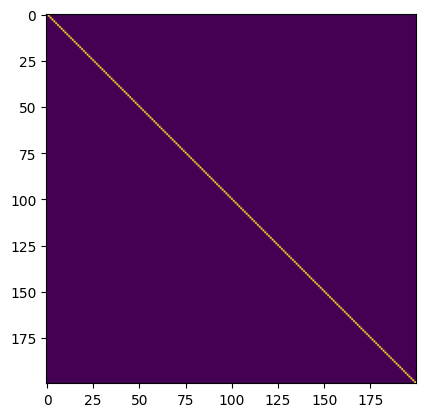

In [9]:
import matplotlib.pyplot as plt

npz = np.load('output/3dmd/x_spectral.npz')
mass = torch.from_numpy(npz['mass'])
evecs = torch.from_numpy(npz['evecs'])
evecs_trans = torch.from_numpy(
    npz['evecs'][:, :200].T * npz['mass'][None]
)


plt.imshow(evecs_trans @ evecs)
plt.show()

In [10]:
{
    'area': mass.sum() / 1e6,  # mm^2 -> m^2
    'dist': 0.016 * (mass.sum() / 1e6).sqrt(),  # 1.6% -> abs geodesic distance (m)
}

{'area': tensor(1.3662), 'dist': tensor(0.0187)}

## Functional Maps

### Organize data

In [43]:
from pathlib import Path
from src.utils.tensor import sparse_np_to_torch, read_sp_mat
from src.dataloader.shape_cor_batch import collate_shape_batch

def get_item(npz_path, return_faces=True, return_L=False, return_mass=True, num_evecs=200, return_evecs=True, return_grad=True):
    item = {}
    spectral_npz = np.load(npz_path)

    assert spectral_npz['k_eig'] >= num_evecs, 'not enough eigenvectors in spectral data'

    # name
    item['name'] = Path(npz_path).stem

    # get vertices and faces
    item['verts'] = torch.from_numpy(spectral_npz['verts'])
    item['verts_mask'] = torch.ones(item['verts'].shape[0], dtype=torch.bool)

    if return_faces:
        item['faces'] = torch.from_numpy(spectral_npz['faces'])

    if return_L:
        item['L'] = sparse_np_to_torch(read_sp_mat(spectral_npz, 'L'))
        
    if return_mass:
        item['mass'] = torch.from_numpy(spectral_npz['mass'])

    if return_evecs:
        item['evecs'] = torch.from_numpy(spectral_npz['evecs'][:, :num_evecs])
        item['evecs_trans'] = torch.from_numpy(
            spectral_npz['evecs'][:, :num_evecs].T * spectral_npz['mass'][None]
        )
        item['evals'] = torch.from_numpy(spectral_npz['evals'][:num_evecs])

    if return_grad:
        item['gradX'] = sparse_np_to_torch(read_sp_mat(spectral_npz, 'gradX'))
        item['gradY'] = sparse_np_to_torch(read_sp_mat(spectral_npz, 'gradY'))

    return item

data = collate_shape_batch([{
    'first': get_item('output/3dmd/x_spectral.npz'),
    'second': get_item('output/3dmd/y_spectral.npz'),
}])

### Network

In [72]:
from src.infra import config

path = '../../config/vec.yaml'
opt = config.load_config(path)
opt.path = path

In [73]:
from src.network.urssm import URSSM_vectorized

network = URSSM_vectorized(opt=opt)
network.load_state_dict(torch.load('output/3dmd/model-800.pth', map_location='cpu'))
network

URSSM_vectorized(
  (point_descriptor): WKS_vectorized()
  (feature_extractor): DiffusionNet_vectorized(
    (first_lin): Linear(in_features=128, out_features=128, bias=True)
    (last_lin): Linear(in_features=128, out_features=256, bias=True)
    (block_0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_mlp_layer_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_mlp_act_000): ReLU()
        (miniMLP_mlp_layer_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_mlp_act_001): ReLU()
        (miniMLP_mlp_layer_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_002): Linear(in_features=128, out_feature

In [75]:
infer = network(data)
infer.keys()

dict_keys(['Cxy', 'Cyx', 'Pxy', 'Pyx'])

In [102]:
from src.utils.fmap import fmap2pointmap_vectorized

data_x, data_y = data['first'], data['second']
evecs_x = data_x['evecs']
evecs_y = data_y['evecs']

p2p = fmap2pointmap_vectorized(
    infer['Cxy'], evecs_x, evecs_y, data['first']['verts_mask'], data['second']['verts_mask'])
p2p, p2p.shape

(tensor([[4033, 4299, 4033,  ..., 4033, 4201, 2621]]), torch.Size([1, 5000]))

In [136]:
from src.utils.fmap import p2p_to_permutation_mat_sparse

Pyx = p2p_to_permutation_mat_sparse(p2p, evecs_x.shape[1])
Pyx.to_dense()[0].sum(axis=0), Pyx.to_dense()[0].sum(axis=1) # <-- dubious

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [ ]:
# compute the point-to-point map
evecs_trans_x = data_x['evecs_trans']
evecs_trans_y = data_y['evecs_trans']

Cxy = evecs_trans_y[0] @ evecs_x[0][p2p[0]]
Pyx = evecs_y[0] @ Cxy @ evecs_trans_x[0]

Pyx.shape, Pyx.sum(axis=0), Pyx.sum(axis=1)

### Visualization

In [140]:
import os
from src.utils.tensor import to_numpy
from src.utils.texture import write_obj_pair

for output_path in ['output/3dmd/clr-grad', 'output/3dmd/symbol-grid']:
    name_x, name_y = 'x', 'y'
    file_x = os.path.join(output_path, f'{name_x}.obj')
    file_y = os.path.join(output_path, f'{name_x}-{name_y}.obj')
    texture_fname = os.path.join(output_path, 'texture.png')
    faces_x, faces_y = to_numpy(data_x['faces'][0]), to_numpy(data_y['faces'][0])
    verts_x, verts_y = to_numpy(data_x['verts'][0]), to_numpy(data_y['verts'][0])

    write_obj_pair(file_x, file_y, verts_x, faces_x, verts_y, faces_y, to_numpy(Pyx.to_dense()), texture_fname)

In [141]:
pl = pv.Plotter()
pl.add_mesh(
    pv.read('output/3dmd/clr-grad/x.obj'),
    texture=pv.read_texture('output/3dmd/clr-grad/texture.png'),
)
pl.add_mesh(
    pv.read('output/3dmd/clr-grad/x-y.obj').translate([1000, 0, 0]),
    texture=pv.read_texture('output/3dmd/clr-grad/texture.png'),
)
pl.camera_position = 'xy'
pl.screenshot('output/3dmd/clr-grad/screenshot.png')
pl.show()

Widget(value='<iframe src="http://localhost:55441/index.html?ui=P_0x4e740f1f0_60&reconnect=auto" class="pyvist…

In [142]:
pl = pv.Plotter()
pl.add_mesh(
    pv.read('output/3dmd/symbol-grid/x.obj'),
    texture=pv.read_texture('output/3dmd/symbol-grid/texture.png'),
)
pl.add_mesh(
    pv.read('output/3dmd/symbol-grid/x-y.obj').translate([1000, 0, 0]),
    texture=pv.read_texture('output/3dmd/symbol-grid/texture.png'),
)
pl.camera_position = 'xy'
pl.screenshot('output/3dmd/symbol-grid/screenshot.png')
pl.show()

Widget(value='<iframe src="http://localhost:55441/index.html?ui=P_0x39af67c70_61&reconnect=auto" class="pyvist…